## Introduction

As we are increasingly using wide gamut colourspaces (*ACES RGB*, *Rec. 2020*, *ProPhoto RGB*) in the VFX industry, the need for better colour analysis tools is more important than ever. Today, nothing prevents an artist to generate or pick colours outside a given volume.

We think that people working with DCC applications from [Autodesk](http://www.autodesk.com/), [Adobe](http://www.adobe.com/) and [The Foundry](http://www.thefoundry.co.uk/) need better tools to work with colour. This is especially true when we tend to work in scene referred lighting with floating point values.

We are using the *ACES RGB* *Sony F35* still life image from this directory for our manipulation:

[https://www.dropbox.com/sh/2uo12yepe8gg422/AAAtzFqm0eJgyf7TDHmTCXQFa/aces?dl=0](https://www.dropbox.com/sh/2uo12yepe8gg422/AAAtzFqm0eJgyf7TDHmTCXQFa/aces?dl=0)

More images are available there: [https://www.dropbox.com/sh/bwfrqgyt20gz4dp/XShJffwvXR](https://www.dropbox.com/sh/bwfrqgyt20gz4dp/XShJffwvXR)

This still life image exhibits a lot of colours that are very hard to reproduce and is a great example for the purpose of this document.

## From ACES RGB Colourspace...

We first read the image using [OpenimageIO](https://sites.google.com/site/openimageio/home) and display it directly onto our *sRGB* display device. We apply the *sRGB* colourspace opto-electronic conversion function and ensure that values are in domain [0, 1] so that [Matplotlib](http://matplotlib.org/) can display the image.

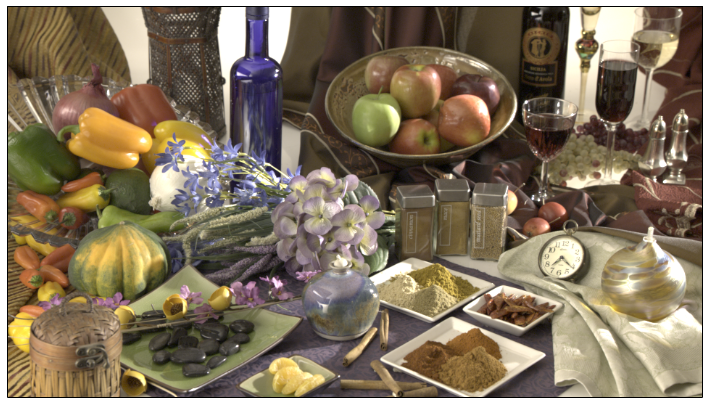

In [1]:
import numpy as np
import pylab
from OpenImageIO import FLOAT, ImageInput

import colour
from colour.plotting import *
from colour.utilities import message_box


def exr_image_as_array(path):
    image = ImageInput.open(path)
    specification = image.spec()

    return np.array(image.read_image(FLOAT)).reshape((specification.height,
                                                      specification.width,
                                                      specification.nchannels))


def image_plot(image,
               transfer_function=colour.sRGB_COLOURSPACE.transfer_function):
    vectorised_oecf = np.vectorize(transfer_function)
    image = np.clip(vectorised_oecf(image), 0, 1)
    pylab.imshow(image)

    settings = {'no_ticks': True,
                'bounding_box': [0, 1, 0, 1],
                'bbox_inches': 'tight',
                'pad_inches': 0}

    aspect(**settings)
    display(**settings)


ACES_image = exr_image_as_array('resources/images/SonyF35.StillLife_medium.exr')
image_plot(ACES_image)

## ... to sRGB Colourspace

We will convert the existing data to *sRGB* colourspace, in order to do so, we first compute the transformation matrix.

> Note: We are using *CAT02* chromatic adaptation transform (CAT).

In [2]:
sRGB_w = colour.sRGB_COLOURSPACE.whitepoint
sRGB_p = colour.sRGB_COLOURSPACE.primaries
sRGB_XYZ_to_RGB = colour.sRGB_COLOURSPACE.XYZ_to_RGB_matrix
sRGB_RGB_to_XYZ = colour.sRGB_COLOURSPACE.RGB_to_XYZ_matrix

ACES_w = colour.ACES_RGB_COLOURSPACE.whitepoint
ACES_p = colour.ACES_RGB_COLOURSPACE.primaries
ACES_XYZ_to_RGB = colour.ACES_RGB_COLOURSPACE.XYZ_to_RGB_matrix
ACES_RGB_to_XYZ = colour.ACES_RGB_COLOURSPACE.RGB_to_XYZ_matrix

message_box('Computing "ACES RGB" colourspace to "sRGB" colourspace matrix.')

cat = colour.chromatic_adaptation_matrix(colour.xy_to_XYZ(ACES_w),
                                         colour.xy_to_XYZ(sRGB_w))
ACES_RGB_to_sRGB_matrix = np.dot(sRGB_XYZ_to_RGB,
                                 np.dot(cat, ACES_RGB_to_XYZ))

print(ACES_RGB_to_sRGB_matrix)

*                                                                             *
*   Computing "ACES RGB" colourspace to "sRGB" colourspace matrix.            *
*                                                                             *
[[ 2.52197696 -1.13706612 -0.38491081]
 [-0.27547671  1.36982658 -0.09434988]
 [-0.01598681 -0.14781833  1.16380514]]


We finally apply the transformation matrix to the image and display it.

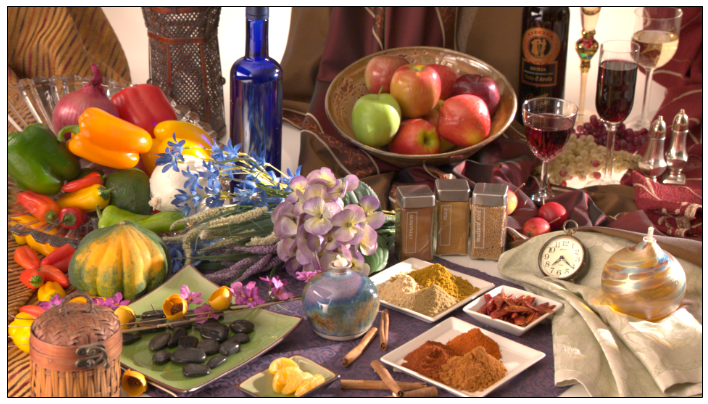

In [3]:
ACES_image_shape = ACES_image.shape
sRGB_image = np.array([np.dot(ACES_RGB_to_sRGB_matrix, RGB) for RGB in ACES_image.reshape((-1, 3))])
sRGB_image = sRGB_image.reshape(ACES_image_shape)
image_plot(sRGB_image)

## Chromaticities Figure

We plot the chromaticities of the *ACES RGB* image pixels onto the *CIE 1931 Chromaticity Diagram* to reveal the current coverage.

/home/vagrant/anaconda/envs/python2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


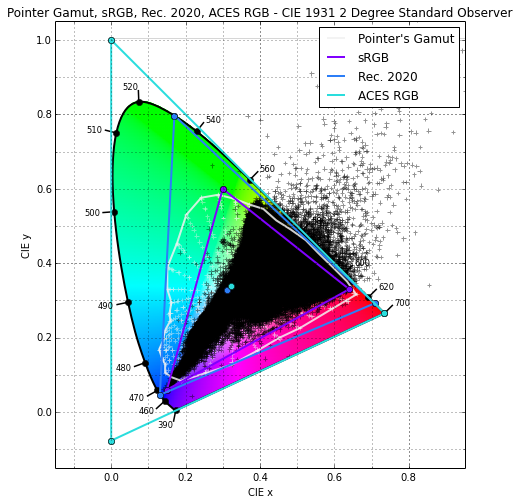

In [4]:
ACES_w = colour.ACES_RGB_COLOURSPACE.whitepoint
ACES_p = colour.ACES_RGB_COLOURSPACE.primaries
ACES_XYZ_to_RGB = colour.ACES_RGB_COLOURSPACE.XYZ_to_RGB_matrix
ACES_RGB_to_XYZ = colour.ACES_RGB_COLOURSPACE.RGB_to_XYZ_matrix


def ACES_to_xy(RGB):
    return colour.XYZ_to_xy(
                colour.RGB_to_XYZ(RGB,
                                  ACES_w,
                                  ACES_w,
                                  ACES_RGB_to_XYZ))


def image_chromaticities_plot(image, to_xy=ACES_to_xy):
    colourspaces_CIE_1931_chromaticity_diagram_plot(
        ['Pointer Gamut', 'sRGB', 'Rec. 2020', 'ACES RGB'],
        standalone=False)

    alpha_p, colour_p = 0.85, 'black'

    xy = np.array([to_xy(RGB) for RGB in image.reshape((-1, 3))])
    pylab.scatter(xy[:, 0], xy[:, 1], alpha=alpha_p / 2, color=colour_p,
                  marker='+')

    display(standalone=True)


image_chromaticities_plot(ACES_image)

As a check, we also plot the chromaticities of the *sRGB* image pixels onto the *CIE 1931 Chromaticity Diagram*.

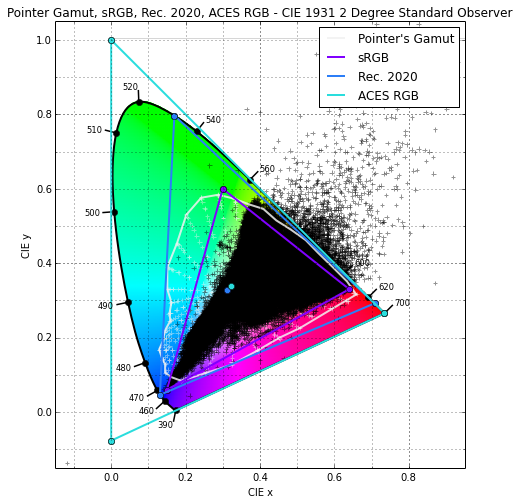

In [5]:
sRGB_CHROMATICITIES_CACHE = {}


def sRGB_to_xy(RGB):
    RGB_key = tuple(RGB)
    if not RGB_key in sRGB_CHROMATICITIES_CACHE:
        sRGB_CHROMATICITIES_CACHE[RGB_key] = (
            colour.XYZ_to_xy(
                colour.RGB_to_XYZ(RGB,
                                  sRGB_w,
                                  sRGB_w,
                                  sRGB_RGB_to_XYZ)))
    return sRGB_CHROMATICITIES_CACHE[RGB_key]

image_chromaticities_plot(sRGB_image, sRGB_to_xy)

Unsurprisingly, *sRGB* colourspace doesn't hold all the colours of the image, however it is interesting to note that the chromaticities are partially outside the spectral locus, illustrating a potential problem with the image: the S-Log1 black level set to code 64 is yielding negative values in that case.

A lot of them are also not contained within *Pointer's Gamut*, which again is not surprising, we are not dealing with true reflectance data but reflected spectra: Reflectance values have already been multiplied by the spectra of multiple different light sources and by the reflected spectra from neighbour surfaces. Pointer's Gamut also doesn't take in account refracted spectra.

## sRGB Colourspace "Illegal" Colours

We isolate image areas representing colours outside *sRGB* colourspace volume boundaries. We qualify any colour outside a given volume "illegal" colour. For practical reasons, we are just considering the projected area onto the chromaticity diagram, but the following computations can be run on complete volumes.

> Note: In the current context, finding colours outside the *sRGB* colourspace volume boundaries is equivalent to check $RGB$ triplets with negative values. 

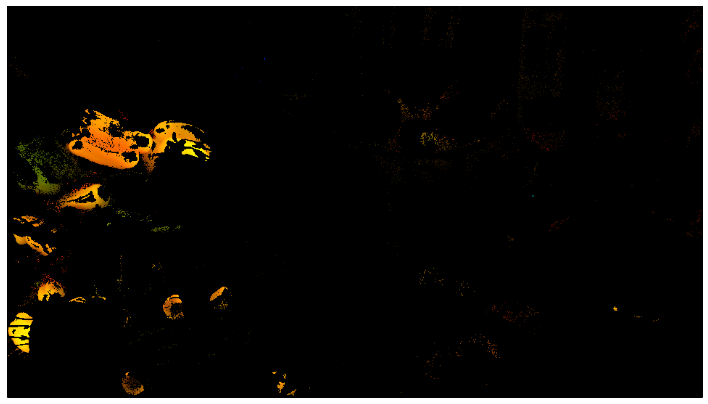

In [6]:
from scipy.spatial import Delaunay


def within_boundaries(point, triangulation):
    simplex = triangulation.find_simplex(point)
    return True if simplex != -1 else False


def mask_legal_colours(image, points, to_xy=sRGB_to_xy):
    triangulation = Delaunay(points)
    image_illegal = np.copy(image).reshape((-1, 3))
    legal_colours_mask = np.array(
        [within_boundaries(to_xy(RGB), triangulation)
         for RGB in
         image_illegal])
    image_illegal[legal_colours_mask] = 0
    return image_illegal.reshape(image.shape)


sRGB_image_illegal = mask_legal_colours(np.copy(sRGB_image), sRGB_p)
image_plot(sRGB_image_illegal)

## Rec. 2020 Colourspace "Illegal" Colours

We isolate image areas representing colours outside *Rec. 2020* colourspace volume boundaries.

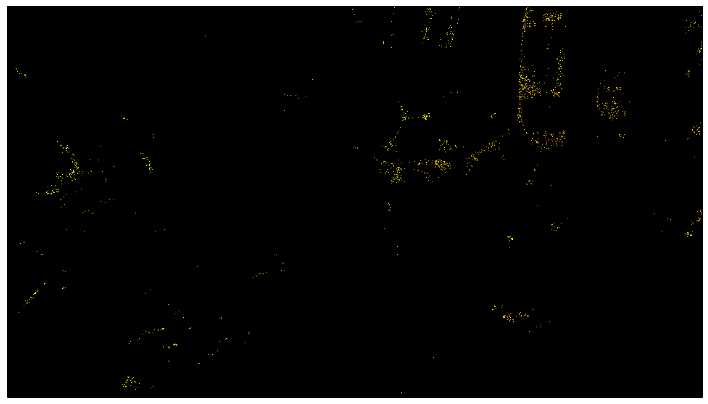

In [7]:
Rec_2020_w = colour.REC_2020_COLOURSPACE.whitepoint
Rec_2020_p = colour.REC_2020_COLOURSPACE.primaries
Rec_2020_XYZ_to_RGB = colour.REC_2020_COLOURSPACE.XYZ_to_RGB_matrix
Rec_2020_RGB_to_XYZ = colour.REC_2020_COLOURSPACE.RGB_to_XYZ_matrix

# Computing *sRGB* to *Rec. 2020* colourspace transformation matrix.
cat = colour.chromatic_adaptation_matrix(
    colour.xy_to_XYZ(sRGB_w),
    colour.xy_to_XYZ(Rec_2020_w))
Rec_2020_to_sRGB_matrix = (
    np.dot(Rec_2020_XYZ_to_RGB,
           np.dot(cat, sRGB_RGB_to_XYZ)))


def Rec_2020_to_xy(RGB):
    return colour.XYZ_to_xy(
        colour.RGB_to_XYZ(RGB,
                          Rec_2020_w,
                          Rec_2020_w,
                          Rec_2020_RGB_to_XYZ))


Rec_2020_image = np.array([np.dot(Rec_2020_to_sRGB_matrix, RGB)
                           for RGB in
                           sRGB_image.reshape((-1, 3))])
Rec_2020_image = Rec_2020_image.reshape(ACES_image_shape)

Rec_2020_image_illegal = (
    mask_legal_colours(np.copy(Rec_2020_image), 
                       Rec_2020_p, 
                       Rec_2020_to_xy))

# Scaling the data to make it more obvious.
Rec_2020_image_illegal *= 100
image_plot(Rec_2020_image_illegal)

## Pointer's Gamut "Illegal" Colours

We isolate image areas representing colours outside *Pointer's Gamut* boundaries.

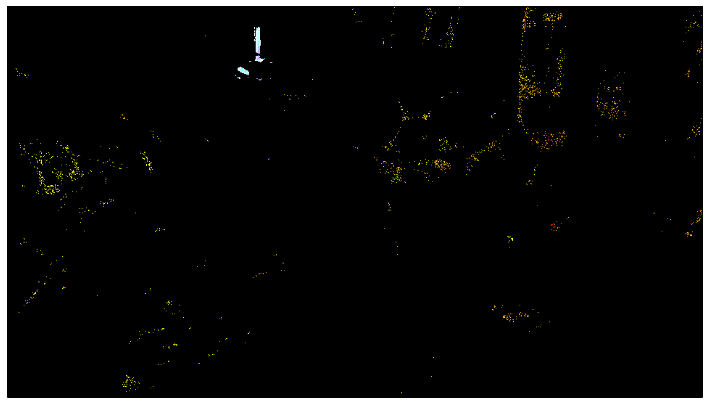

In [8]:
pointer_gamut_illegal_image = mask_legal_colours(sRGB_image, colour.POINTER_GAMUT_BOUNDARIES)

# Scaling the data to make it more obvious.
pointer_gamut_illegal_image *= 100
image_plot(pointer_gamut_illegal_image)

## Spectral Locus "Illegal" Colours

We isolate image areas representing imaginary colours outside the spectral locus boundaries.

> Note: They are visible in the image below because we ensure that the final displayed colours are within [0, 1] domain.

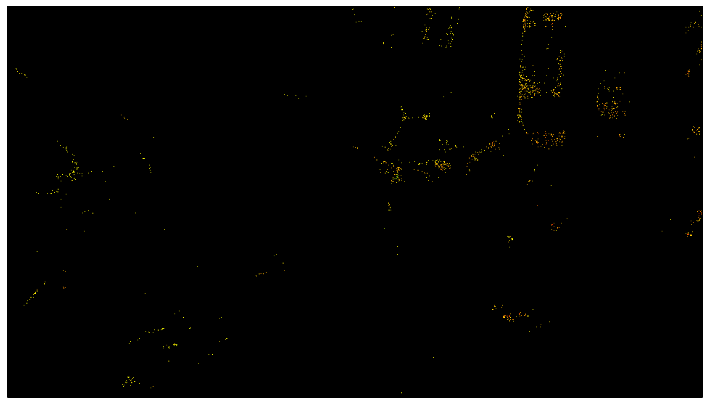

In [9]:
cmfs = colour.CMFS.get('CIE 1931 2 Degree Standard Observer')
spectral_locus_xy = np.array([colour.XYZ_to_xy(x) for x in cmfs.values])

spectral_locus_illegal_image = mask_legal_colours(sRGB_image, spectral_locus_xy)

# Scaling the data to make it more obvious.
spectral_locus_illegal_image *= 100
image_plot(spectral_locus_illegal_image)

## Conclusion

The above images illustrate a simple case where we have taken a real world frame. More complex situations arise when you use an HDRI similarly exhibiting a wide colours volume to lit a scene, yielding "illegal" colours very quickly.

As it was recentely shown by [Steve Agland](http://nbviewer.ipython.org/gist/sagland/3c791e79353673fd24fa) and [us](http://colour-science.org/posts/about-rendering-engines-colourspaces-agnosticism/), it has turned into a problematic issue. 

We don't think there is an easy and elegant way to fix that however DCC applications vendors can help us by providing new tools that will let us analyse colours properly. Such tools would also have shown that there is an issue with the image we are using.

Follows some specifications on what we think would be useful:

Given the following major volumes:

- **Movie / production colourspace volume**.
- **Arbitrary / current colourspace volume**.
- **Spectral locus volume**.
- **Real object surface colour gamut volume and / or Macadam limits**.

We define a simple function $F$ returning if a given colour $C$ lies within a volume $V$ as follows: 

$$
\begin{equation}
F=C\in V
\end{equation}
$$

We can then build the following basic tools around that function: 

- **Display Tools**: Visual feedback of colours according to the mask produced by $F$. They can be shown using zebras, isolated like the above images, etc...
- **Selection Tools**: Colours selection using $F$ as a mask. 
- **Colour Picking Tools**: Colours picking while using $F$ as a constraint.
- **Correction Tools**: Colours correction while using $F$ as a mask and the **Display Tools**.

The above tools are really the basics of what would be needed. Autodesk Maya, Side FX Houdini, The Foundry Nuke, etc..., should have those capabilities and they are straightforward to implement.